In [1]:
from scipy.spatial.distance import cdist
import commoncode as commoncode
import numpy as np
import matplotlib.pyplot as plt
import SkewGP as SkewGP
import GPy as GPy
from matplotlib import pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import norm
import pymc3 as pm


## We  generate some data

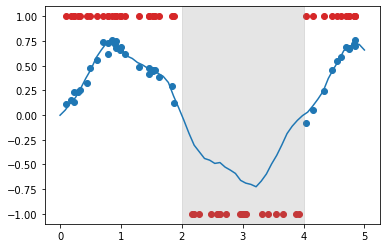

In [2]:
def fun(x,noise_std=0.1):
    v=(4*np.sin(x/2*np.pi)-0.5*np.sin(2*x*np.pi))/6+np.random.randn(len(x))*noise_std
    return v

σ=0.05
np.random.seed(42)
x=np.random.rand(60)*5
indd=np.where((x<2)|(x>4))[0]
y=fun(x,noise_std=σ)
plt.scatter(x[indd],y[indd])



#We generate the matrices for preferences
w=-np.ones(len(x))
w[indd]=1
W=np.diag(w)
Z=np.zeros((W.shape[0],1))
c=np.zeros((len(indd),len(x)))
for i in range(len(indd)):
    c[i,indd[i]]=1
C=c
X=x.reshape(-1,1)
Y=y[indd].reshape(-1,1)

xx = np.linspace(0,5,60)
plt.plot(xx,fun(xx,noise_std=σ))
plt.axvspan(2, 4,  color='gray', alpha=0.2)
plt.scatter(x,w,color='C23')

The above plot shows the true function we used to generate the data (in blue), the numeric data (blue points) and  binary data (red points where $y_1=1$ means valid and  $y_i=-1$ means non-valid)

We define the Kernel and an empty skewness function for SkewGP. We are going to use  a zero dimension SkewGP, which is a GP prior and so we do not need Delta.

In [3]:
def Kernel(X1,X2,params,diag_=False):
        lengthscale=params['lengthscale']['value']
        variance   =params['variance']['value']
        if diag_==False:
            diffs = cdist(np.atleast_2d(X1)/ lengthscale, np.atleast_2d(X2) / lengthscale, metric='sqeuclidean')
        else:
            diffs = np.sum((np.atleast_2d(X1)/ lengthscale-np.atleast_2d(X2)/ lengthscale)*(np.atleast_2d(X1)/ lengthscale-np.atleast_2d(X2)/ lengthscale),axis=1)
        return variance * np.exp(-0.5 * diffs)
    
def Delta(X,params):
    #empty
    return []

noise_variance = σ**2
logexp=commoncode.logexp()
latent_dim=0
params0={'lengthscale': {'value':np.array([1.0]), 
                    'range':np.vstack([[0.00001, 50.0]]),
                    'transform': logexp},
         'variance': {'value':np.array([1.0]), 
                    'range':np.vstack([[0.001, 100.0]]),
                    'transform': logexp},
         'noise_variance': {'value':np.array([noise_variance]), 
                    'range':np.vstack([[0.000001, 50.001]]),
                    'transform': logexp}
      }

model = SkewGP.SkewGP(X,Kernel, Delta, params0, W=W, C=C, Y=Y, Z=Z,  latent_dim =0, type_y='mixed', jitter=1e-4)
#we optimize the hyperparameters
ml=model.optimize(max_iters=300) 
print("Marginal Likelihood",ml)

Iteration 0  37.38650190897336
Marginal Likelihood 37.38650190897336


In [4]:
model.params


{'lengthscale': {'value': array([0.26254082]),
  'range': array([[1.e-05, 5.e+01]]),
  'transform': <commoncode.logexp at 0x7f8d5c009bb0>},
 'variance': {'value': array([0.12280286]),
  'range': array([[1.e-03, 1.e+02]]),
  'transform': <commoncode.logexp at 0x7f8d5c009bb0>},
 'noise_variance': {'value': array([0.00197453]),
  'range': array([[1.0000e-06, 5.0001e+01]]),
  'transform': <commoncode.logexp at 0x7f8d5c009bb0>}}

In [5]:
Xpred=np.linspace(0,5.5,200)[:,None]
print(Xpred.shape)
predictions=model.predict(Xpred,nsamples=10000);

(200, 1)
Start Lin-Ess sampler


 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:337: UserWarning:hpd will be deprecated Please replace hdi
 /home/benavoli/anaconda3/envs/myenv/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning:hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


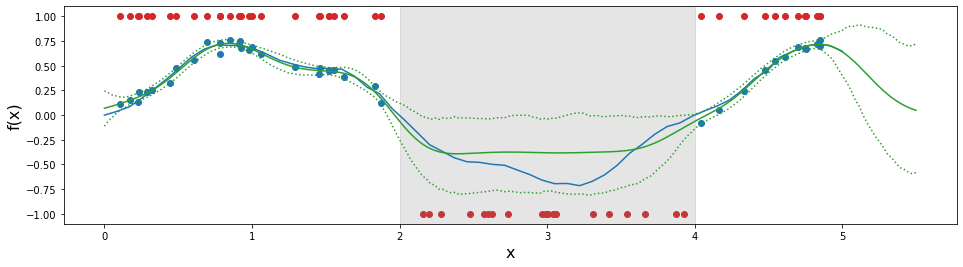

In [6]:
plt.figure(figsize=(16,4))
plt.scatter(x[indd],y[indd])
plt.plot(xx,fun(xx,noise_std=σ))
plt.axvspan(2, 4,  color='gray', alpha=0.2)
plt.scatter(x,w,color='C23')


#we compute the credible intervals
credib_int = pm.stats.hpd(predictions.T)
#we plot the latent function mean and credible interval
plt.plot(Xpred[:,0],credib_int[:,1],color='C2', linestyle=':')
plt.plot(Xpred[:,0],credib_int[:,0],color='C2', linestyle=':')
plt.plot(Xpred[:,0],np.mean(predictions,axis=1), label='mean',color='C2')
plt.xlabel("x",fontsize=16)
plt.ylabel("f(x)",fontsize=16);